In [18]:
import os
import copy
import numpy as np
import astra
import elasticdeform
import itertools
import SimpleITK as sitk
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt 

path = r'C:\Users\guusv\Google Drive\Documenten\RU\Master Thesis\Code\example scans\example scans\scan'
os.chdir(path)
print(path)

C:\Users\guusv\Google Drive\Documenten\RU\Master Thesis\Code\example scans\example scans\scan


(548, 512, 512)


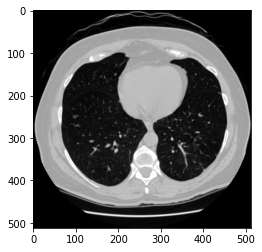

In [19]:
# from https://stackoverflow.com/questions/37290631/reading-mhd-raw-format-in-python
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, origin and spacing of the image.
'''

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

def normalize(img):
    
    img = img+np.absolute(np.min(img))

    img = img/np.max(img)
    
    return img

# load scan (as z,y,x)
scan, _, _ = load_itk('1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545.mhd')

# clip scans to Hounsfield Units -1000 (air) and 400 (bone)
scan = np.clip(scan, -1000, 400)

# normalize between 0 and 1
scan = normalize(scan)

# show dimensions and example slice
print(img.shape)
plt.imshow(img[220,:,:], cmap='gray')

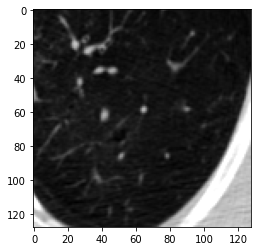

In [20]:
# create a patch by specifying the topleft corner and patch size
x,y,z = (290,250,430)
patch_size = 128
patch = img[z,y:y+patch_size,x:x+patch_size]
plt.imshow(patch, cmap='gray')

In [70]:
# show an image
def show(img, title=""):
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.clim(0,1)
    plt.axis('off')
    plt.show()

# create astra projector
def make_projector(angle, vol_geom, nr_detectors):
    proj_geom = astra.create_proj_geom('parallel', 1, nr_detectors, [angle])
    projector_id = astra.creators.create_projector('line', proj_geom, vol_geom)
    return projector_id

# create a random displacement vector grid (fig 5a, 5b and 5c in thesis)
def get_random_displacement(dir_x, dir_y):
    # create 2D Gaussian matrix 
    M = 9
    x, y = np.meshgrid(np.linspace(-1,1,M), np.linspace(-1,1,M))
    d = np.sqrt(x*x+y*y)
    
    # random sigma, high value creates uniform motion, low value creates motion focused around single grid point
    sigma=np.random.uniform(0.1,1.2)
    mu = 0
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    
    # N x N displacement vector grid
    N = 5
    displacement= np.zeros((2 , N, N))
    
    # take random submatrix to simulate random motion source location
    center_x = int(np.random.uniform(0,N-1))
    center_y = int(np.random.uniform(0,N-1))

    # displacement vectors x-values
    displacement[1,:,:]=g[center_x:center_x+N,center_y:center_y+N]*dir_x+1
    # displacement vectors y-values
    displacement[0,:,:]=g[center_x:center_x+N,center_y:center_y+N]*dir_y+1
    
    # clip back the motion vectors to the severity of the original motion direction
    max_movement = np.max((dir_x, dir_y))
    displacement = np.clip(displacement.astype(np.int32), -max_movement, max_movement)

    return displacement

# adapted version of https://github.com/gvtulder/elasticdeform that also returns motion mask
def deform_grid_py(X, displacement, order=3, mode='constant', cval=0.0, crop=None, prefilter=True, axis=None):
    if axis is None:
        axis = tuple(range(X.ndim))
    elif isinstance(axis, int):
        axis = (axis,)

    # compute number of control points in each dimension
    points = [displacement[0].shape[d] for d in range(len(axis))]

    # creates the grid of coordinates of the points of the image (an ndim array per dimension)
    coordinates = np.meshgrid(*[np.arange(X.shape[d]) for d in axis], indexing='ij')
    # creates the grid of coordinates of the points of the image in the "deformation grid" frame of reference
    xi = np.meshgrid(*[np.linspace(0, p - 1, X.shape[d]) for d, p in zip(axis, points)], indexing='ij')

    if crop is not None:
        coordinates = [c[crop] for c in coordinates]
        xi = [x[crop] for x in xi]
        # crop is given only for the axes in axis, convert to all dimensions for the output
        crop = tuple(crop[axis.index(i)] if i in axis else slice(None) for i in range(X.ndim))
    else:
        crop = (slice(None),) * X.ndim
    move_mask = []
    # add the displacement to the coordinates
    for i in range(len(axis)):
        yd = scipy.ndimage.map_coordinates(displacement[i], xi, order=3)
        move_mask.append(yd)
        # adding the displacement
        coordinates[i] = np.add(coordinates[i], yd)
        
    out = np.zeros(X[crop].shape, dtype=X.dtype)
    # iterate over the non-deformed axes
    iter_axes = [range(X.shape[d]) if d not in axis else [slice(None)]
                 for d in range(X.ndim)]
    for a in itertools.product(*iter_axes):
        scipy.ndimage.map_coordinates(X[a], coordinates, output=out[a],
                                      order=order, cval=cval, mode=mode, prefilter=prefilter)
    return out, np.array(move_mask)

In [80]:
# artificial motion artifact creation
# input:      patch of lung tissue, 
            # lung mask belonging to patch, use np.ones(patch_size) if no lung mask is available
            # movement in x-direction(pixels), 
            # movement in y-direction(pixels), 
            # size of centerpatch

def create_artifact_elasticdeform(img, mask, dir_x, dir_y, patch_size):
    size_x, size_y = img.shape
    width, height = patch_size
    
    # padding
    padsize = np.max((np.absolute(dir_x), np.absolute(dir_y)))
    
    #coordinates of top-left corner of patch in background
    x = int(size_x/2 - width/2)
    y = int(size_y/2 - height/2)

    background = np.zeros((size_x + 2*padsize, size_y + 2*padsize))
    
    # copy of the original patch
    temp=copy.copy(img)
    
    # nr of angles in which the projector will take pictures
    nr_angles=360
    
    # the (radian) angles in which the projector will create a projection 
    angles = np.linspace(0, np.pi, nr_angles)
    
    # get a random displacement vector grid
    displacement = get_random_displacement(dir_x, dir_y)
    
    # N, number of grid points for elastic deformation
    order = 5
    
    # deform the lung mask to deal with lungborder artifacts later and create the movement mask
    mask, movement_vectors_mask = deform_grid_py(mask, displacement, order=order)
    
    # take the movement vectors for each pixel in the input image and compute the vector lengths(motion severity)
    move_mask = np.linalg.norm(movement_vectors_mask, axis=0)
    
    # make the mask binary again
    mask = mask > 0.9
    mask = mask * 1

    # determine after which projection angles grid points need to move and the image in the scanner needs to be swapped
    angles_idxs = np.array([])
    angles_dict = {}
    for a in np.unique(displacement):
        if np.abs(a) > 0:
            angles_idxs =np.linspace(0,nr_angles, np.abs(a)+2).astype(np.int32)
            for angle in angles_idxs:
                if not angle in angles_dict:
                    angles_dict[angle]=[a]
                else:
                    angles_dict[angle].append(a)
    
    

    #the indices of the angles in which the image needs to be moved 
    angles_x = np.linspace(0, nr_angles, np.absolute(dir_x)+2).astype(np.int32)
    angles_y = np.linspace(0, nr_angles, np.absolute(dir_y)+2).astype(np.int32)
    
    #remove 0 and pi as angles to move the image
    angles_x = np.delete(angles_x,0)
    angles_x = np.delete(angles_x,len(angles_x)-1)
    angles_y = np.delete(angles_y,0)
    angles_y = np.delete(angles_y,len(angles_y)-1)
    
    #create one unique list after which indices of projection angles the image should be moved
    angles_idx = np.concatenate((angles_x, angles_y))
    angles_idx = np.unique(angles_idx)
    
    # specify the number of detectors the scanner has
    nr_detectors=np.max(img.shape)+128
    
    # initialize data for astra scanner
    vol_geom = astra.creators.create_vol_geom(temp.shape[0], temp.shape[1])
    sinogram=np.zeros((nr_angles, nr_detectors))
    
    # Step 1: simulate acquisition of CT scan
    
    # start simulation
    for i, angle in enumerate(angles):
        # create a new projector for each projection
        projector_id = make_projector(angle, vol_geom, nr_detectors)
        
        # if the current angle is in the dict, the image in the scanner needs to be moved slightly and replaced
        if i in angles_dict:
            # determine which grid points need to move by 1 pixel
            idx = np.zeros(displacement.shape)
            for j in angles_dict[i]:
                idx += displacement == j
            idx=idx>0
            idx=idx*1
            idx[0,:,:] = idx[0,:,:]*np.sign(dir_y)
            idx[1,:,:] = idx[1,:,:]*np.sign(dir_x)
            # deform and update the image in the scanner
            temp, _ = deform_grid_py(temp, idx*1.0, order=order)
            
   
        # create artificial sinogram of one angle (add one column for the current projection)    
        (sino_id, sino) = astra.creators.create_sino(temp, projector_id, returnData=True, gpuIndex=None)
        
        #store sinograms of all angles
        sinogram[i,:]=sino
        
        # remove the projector
        astra.projector.delete(projector_id)
        
    # clean up as the simulation of the scan is done 
    astra.projector.clear()
    
    # Step 2: reconstruction of the patch given projection data
    
    # create new projector for reconstruction
    proj_geom = astra.create_proj_geom('parallel', 1, nr_detectors, np.linspace(0, np.pi, nr_angles))
    projector_id = astra.creators.create_projector('line', proj_geom, vol_geom) 
    
    # load sinogram data as sinogram object
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    
    # create empty reconstruction volume
    reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)
    
    # initialize reconstruction algorithm
    alg_cfg = astra.astra_dict('FBP')
    alg_cfg['ProjectorId'] = projector_id
    alg_cfg['ProjectionDataId'] = sinogram_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    
    # create reconstruction from sinogram
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(reconstruction_id)
    
    # for extracting center patch of reconstruction
    patch_x = int(reconstruction.shape[0]/2 - width/2)
    patch_y = int(reconstruction.shape[1]/2 - height/2)
    
    # for extracting center patch of original image for comparison
    template_x = int(img.shape[0]/2 - width/2)
    template_y = int(img.shape[1]/2 - height/2)

    # extract center patch with given dimensions
    patch=reconstruction[patch_x:patch_x+width, patch_y:patch_y+height]
    # do the same for the lung mask
    mask = mask[y:y+height, x:x+width]
    # and the original patch for comparison
    temp = temp[y:y+height, x:x+width]
    # and the movement mask
    move_mask = move_mask[y:y+height, x:x+width]
    
    # set everyting outside of lung mask to 0 (also removes lungborder artifacts)
    idxs = mask<1    
    patch[idxs] = 0
    
    # apply a small amount of Gaussian filtering to deal with pixelation
    patch = gaussian_filter(patch, sigma=0.5)
    # for comparison also for the original 
    temp = gaussian_filter(temp, sigma=0.5)
    
    # clip back the patch to a range of 0, 1
    patch=np.clip(patch, 0, 1)

    return patch, temp, move_mask

# binary mask specifying which pixels are lung tissue, lung masks can be generated from scans using e.g. https://github.com/JoHof/lungmask
# not using mask might result in lungborder artifacts or the simulation of a deforming ribcage (which is unrealistic)
# if no mask is available use:
patch_mask = np.ones((patch_size, patch_size))

# specify the motion direction in pixels
dir_x, dir_y = (9,0)
        
result, original, move_mask = create_artifact_elasticdeform(patch,patch_mask, dir_x,dir_y,(64,64))

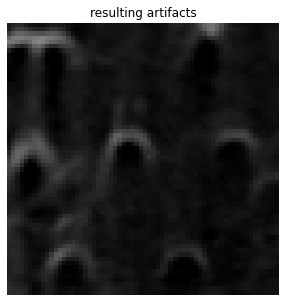

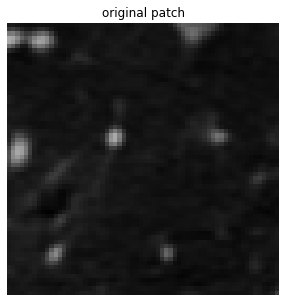

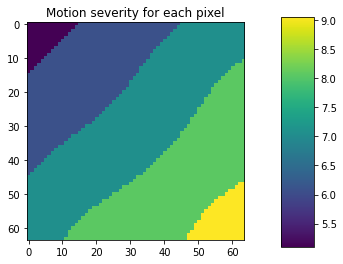

In [81]:
show(result, 'resulting artifacts')
show(original, 'original patch')

plt.title('Motion severity for each pixel')
plt.imshow(move_mask)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
